In [9]:
#uncomment line below and run if not yet installed
#! pip install scikit-learn-extra

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")
import math

## Additional imports can be inlcuded here
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn_extra.cluster import KMedoids
from sklearn import metrics


In [36]:
def make_pds (norm=None, dezero=None, norm_vis=None):
    '''Input: norm - if True, then the consumption values for each plant will be normalized
        dezero - if True, then removes all plants that have a value of 0 consumption at some point
        norm_vis - if True, then uses normalized time series for result (visualization) dataframe
    Output: a matrix df and a results df that has timeseries and location data for each plant'''
    if norm and dezero:
        dmatrix = pd.read_csv('../Merging/DTW_Matrix_Norm_No0.csv')
    elif norm:
        dmatrix = pd.read_csv('../Merging/DTW_Matrix_Norm.csv')
    elif dezero:
        dmatrix = pd.read_csv('../Merging/DTW_Matrix_Raw_No0.csv')
    else:
        dmatrix = pd.read_csv('../Merging/DTW_Matrix_Raw.csv')
        
    if norm_vis:
        results = pd.read_csv('../Merging/Merge_Norm.csv')
    else:
        results = pd.read_csv('../Merging/Merge_Raw.csv')
    
    return dmatrix, results

In [39]:
def hierarchical_cluster (dmatrix, k):
    '''Input: K number of clusters to make, and a distance matrix
    Output: df with cluster labels and plant codes'''
    
    model = AgglomerativeClustering(affinity='precomputed', n_clusters=k, linkage='complete').fit(dmatrix)
    labels = model.labels_
    results = pd.DataFrame(data=[labels, dmatrix.columns]).T
    results.columns=[f'{k}_Clusters','plantCode'] 
    results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results

In [22]:
def kMediods_cluster (dmatrix, k):
    '''Input: K number of clusters to make, and a distance matrix
    Output: df with cluster labels and plant codes'''
    
    model = KMedoids(n_clusters=k, random_state=0, metric='precomputed').fit(dmatrix)
    labels = model.labels_
    results = pd.DataFrame(data=[labels, dmatrix.columns]).T
    results.columns=[f'{k}_Clusters','plantCode'] 
    results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results

In [112]:
def DBSCAN(dmatrix, eps=0.5, min_samples=5, ):
    #Not liking the metric metric="precomputed"
    '''Input: K number of clusters to make, and a distance matrix
    Output: df with cluster labels and plant codes'''
    
    model = DBSCAN(metric='precomputed').fit(dmatrix)
    labels = model.labels_
    results = pd.DataFrame(data=[labels, dmatrix.columns]).T
    results.columns=[f'{k}_Clusters','plantCode'] 
    results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results

In [116]:
def AffinityPropagation(dmatrix, damping=.05, max_iter=200):
    #Not liking the metric metric="precomputed"
    '''Input: K number of clusters to make, and a distance matrix
    Output: df with cluster labels and plant codes'''
    
    model = AffinityPropagation(damping=damping, max_iter=max_iter, metric='precomputed').fit(dmatrix)
    labels = model.labels_
    results = pd.DataFrame(data=[labels, dmatrix.columns]).T
    results.columns=[f'{k}_Clusters','plantCode'] 
    results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results

In [64]:
def distribution_by_state(results, k):
    '''Input: a results data frame and k - the number of clusters sought for
    Output: prints out the breakdown of states for each cluster for each clustering 1 to k'''
    crosstabs = []
    for result in results.columns[-k:]:
        #print(pd.crosstab(results[result],results['state']))
        crosstabs.append(pd.crosstab(results[result],results['state']))
    
    return print([x for x in crosstabs])

In [102]:
def plot_result (results, title='None'):
    fig, [ax1, ax2] = plt.subplots(1,2,figsize=(14, 5))
    colors = ['r','g','b','y','m','c','k', 'orange', 'teal', 'darkorchid']
    
    labels = results.columns[-1]
    k = len(results[labels].unique())
    
    ax1.xaxis.set_ticks([])
    ax2.xaxis.set_ticks([])
    
    for i,state in enumerate(results['state'].unique()):
        ax1.plot(results.query("state==@state").iloc[:,4:-1].T, alpha=.25, color=colors[i])
        ax1.title.set_text('Clustered by State')
    
    for i in range(k):
        ax2.plot(results[results[labels] == i].iloc[:,4:-1].T, alpha=.25, color=colors[i])
        ax2.title.set_text(f'{title} {k} Clusters')
    
    return plt.show()

In [92]:
def cluster_result (norm=None, dezero=None, norm_vis=None, k=6, model='hierarchical',
                    damping=.05, max_iter=200, eps=0.5, min_samples=5,
                    dist=None, plot=None, geoplot=None, title=None):
    '''Input: norm - if True, then the consumption values for each plant will be normalized
        dezero - if True, then removes all plants that have a value of 0 consumption at some point
        norm_vis - if True, then uses normalized time series for result (visualization) dataframe
        k - the number of clusters to look for (3-k)
        model - which clustering model to use
    Output: distribution, plot, geoplot, or df of the model results'''
    
    dmatrix, results = make_pds (norm=norm, dezero=dezero, norm_vis=norm_vis)
    
    if model == 'KMediods':
        result = kMediods_cluster (dmatrix, k)
    elif model ==  'AffinityProp':
        result = AffinityPropagation(dmatrix, damping=damping, max_iter=max_iter)
    elif model == 'DBSCAN':
        DBSCAN(dmatrix, eps=eps, min_samples=min_samples)
    else:
        result = hierarchical_cluster(dmatrix, k)
    
    results = pd.merge(results, result, how='left', left_on='plantCode', right_on='plantCode')
    
    results = results.dropna()
    
    if dist:
        distribution_by_state(results, 1)
        
    if plot:
        return plot_result (results, title)
        
    if geoplot:
        return print('not ready yet')
        
    return results

In [ ]:
def plot_results_k (results, k):
    '''Input: results - df with time series data and k columns with cluster labels
    Output: makes a plot for each clustering by state and k-2 to k'''
    cols = 2
    rows = (k)//2
    
    fig, axs = plt.subplots(rows,cols,figsize=(14, 20))
    colors = ['r','g','b','y','m','c','k', 'orange', 'teal', 'darkorchid']
    
    K_cols = results.columns[-1]
    count = -k
    
    for row in range(rows):
        for col in range(cols):
            axs[row][col].xaxis.set_ticks(np.arange(2019, 2020, 1))
            if count == -k:
                for i,state in enumerate(results['state'].unique()):
                    axs[row][col].plot(results.query("state==@state").iloc[:,4:-k].T, alpha=.25, color=colors[i])
                    axs[row][col].title.set_text('Clustered by State')
                count +=2
            elif count == 0:
                pass
            else:
                k_col = results.columns[count]
                for i in range(0,k+count+1):
                    axs[row][col].plot(results[results[k_col] == i].iloc[:,4:-k].T, alpha=.25, color=colors[i])
                    axs[row][col].title.set_text(f'{k_col}')
                count += 1

    return plt.show()

In [65]:
def cluster_k_results (norm=None, dezero=None, norm_vis=None, k=6, model='hierarchical',
                      dist=None, plot=None, geoplot=None):
    '''Input: norm - if True, then the consumption values for each plant will be normalized
        dezero - if True, then removes all plants that have a value of 0 consumption at some point
        norm_vis - if True, then uses normalized time series for result (visualization) dataframe
        k - the number of clusters to look for (3-k)
        model - which clustering model to use
    Output: distribution matrix by state, plot, geeplot, or df of the model results for range of k-2 to k labels
        for clustering algorithm'''
    
    dmatrix, results = make_pds (norm=norm, dezero=dezero, norm_vis=norm_vis)
    
    for i in range(1,k+1):
        if model == 'KMediods':
            result = kMediods_cluster (dmatrix, i)
        else:
            result = hierarchical_cluster(dmatrix, i)
        results = pd.merge(results, result, how='left', left_on='plantCode', right_on='plantCode')
    
    results = results.dropna()
    
    if dist:
        distribution_by_state(results, k)
        
    if plot:
        return plot_results_k (results, k)
        
    if geoplot:
        return print('not ready yet')
        
    return results
        

Hierarchical Clustering: Raw Data, All values, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           46  19  78   9, state       FL  MI  TX  WA
2_Clusters                
0           45  19  78   9
1            1   0   0   0, state       FL  MI  TX  WA
3_Clusters                
0           34  18  65   9
1            1   0   0   0
2           11   1  13   0, state       FL  MI  TX  WA
4_Clusters                
0           11   1  13   0
1           25  15  25   8
2            9   3  40   1
3            1   0   0   0, state       FL  MI  TX  WA
5_Clusters                
0            9   3  40   1
1           25  15  25   8
2            4   1   2   0
3            1   0   0   0
4            7   0  11   0, state       FL  MI  TX  WA
6_Clusters                
0            3   0  13   0
1           25  15  25   8
2            4   1   2   0
3            1   0   0   0
4            7   0  11   0
5            6   3  27   1, state       FL  MI  TX  WA
7_Clu

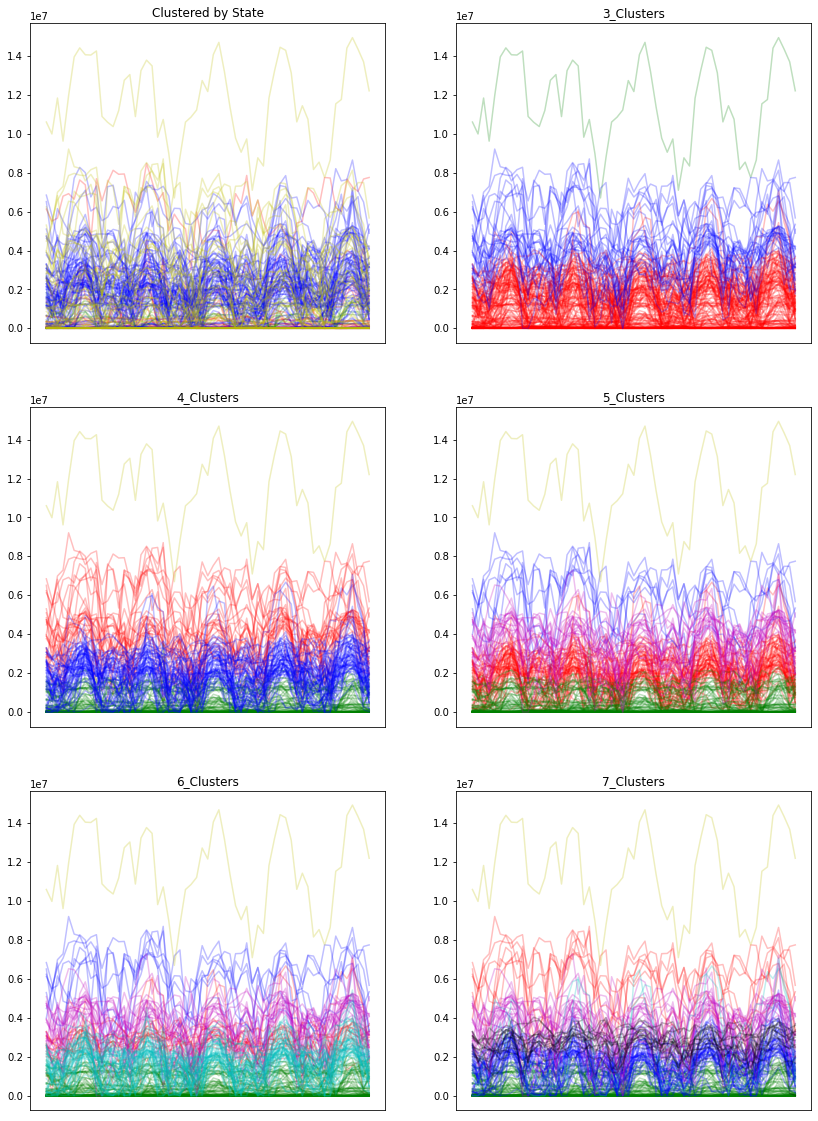

In [73]:
print('Hierarchical Clustering: Raw Data, All values, Raw Data Visualization')
results = cluster_k_results (norm=None, dezero=None, norm_vis=None, k=7, model='hierarchical',
                             dist = True, plot=True)
results

Hierarchical Clustering: Normalized Data, All values, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           42  19  74   9, state       FL  MI  TX  WA
2_Clusters                
0           42  18  73   9
1            0   1   1   0, state       FL  MI  TX  WA
3_Clusters                
0            0   1   1   0
1           39  18  73   9
2            3   0   0   0, state       FL  MI  TX  WA
4_Clusters                
0           39  18  73   9
1            0   1   0   0
2            3   0   0   0
3            0   0   1   0, state       FL  MI  TX  WA
5_Clusters                
0           39  16  73   9
1            0   2   0   0
2            3   0   0   0
3            0   0   1   0
4            0   1   0   0, state       FL  MI  TX  WA
6_Clusters                
0           38  16  72   8
1            0   2   0   0
2            3   0   0   0
3            0   0   1   0
4            0   1   0   0
5            1   0   1   1, state       FL  MI  TX  W

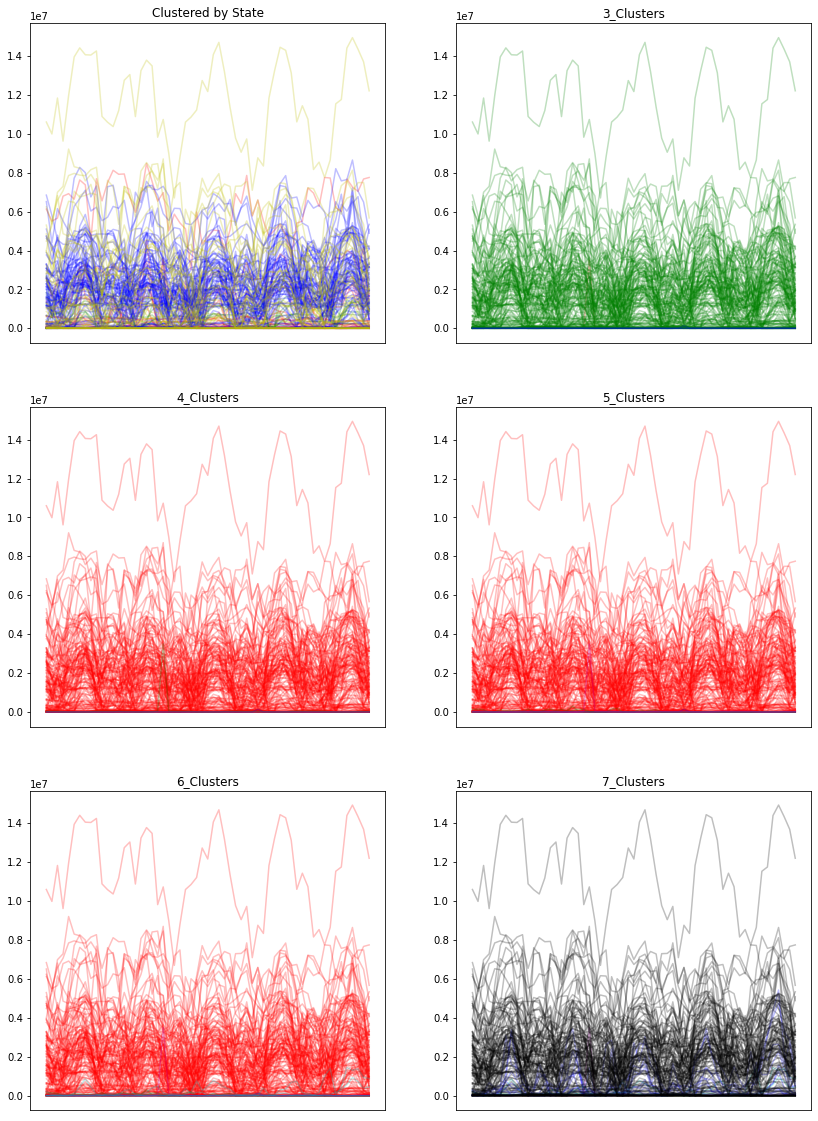

In [74]:
print('Hierarchical Clustering: Normalized Data, All values, Raw Data Visualization')
results = cluster_k_results (norm=True, dezero=None, norm_vis=None, k=7, model='hierarchical',
                             dist = True, plot=True)
results

Hierarchical Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           29  11  51   1, state       FL  MI  TX  WA
2_Clusters                
0            2   2   5   0
1           27   9  46   1, state       FL  MI  TX  WA
3_Clusters                
0           27   9  46   1
1            1   2   5   0
2            1   0   0   0, state       FL  MI  TX  WA
4_Clusters                
0            1   2   5   0
1           27   9  45   1
2            1   0   0   0
3            0   0   1   0, state       FL  MI  TX  WA
5_Clusters                
0            1   2   3   0
1           27   9  45   1
2            1   0   0   0
3            0   0   1   0
4            0   0   2   0, state       FL  MI  TX  WA
6_Clusters                
0            1   1   0   0
1           27   9  45   1
2            0   1   3   0
3            0   0   1   0
4            0   0   2   0
5            1   0   0   0, state       FL  MI  TX

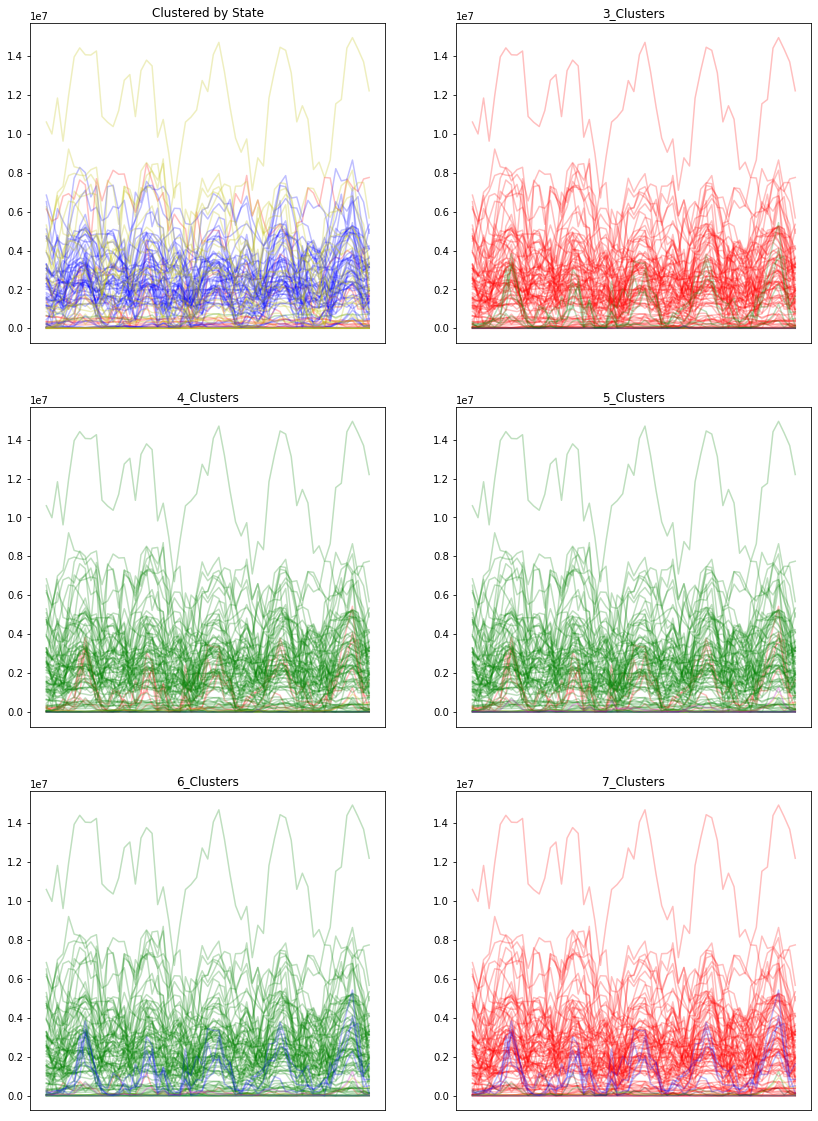

In [75]:
print('Hierarchical Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization')
results = cluster_k_results (norm=True, dezero=True, norm_vis=None, k=7, model='hierarchical',
                             dist = True, plot=True)
results

Hierarchical Clustering: Raw Data, Zeros Dropped, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           29  11  51   1, state       FL  MI  TX  WA
2_Clusters                
0           28  11  51   1
1            1   0   0   0, state       FL  MI  TX  WA
3_Clusters                
0            9   1  18   0
1            1   0   0   0
2           19  10  33   1, state       FL  MI  TX  WA
4_Clusters                
0           19  10  33   1
1            4   1   2   0
2            5   0  16   0
3            1   0   0   0, state       FL  MI  TX  WA
5_Clusters                
0            5   0  16   0
1            4   1   2   0
2            9   3  27   0
3            1   0   0   0
4           10   7   6   1, state       FL  MI  TX  WA
6_Clusters                
0            4   1   2   0
1            5   0  14   0
2            9   3  27   0
3            1   0   0   0
4           10   7   6   1
5            0   0   2   0, state       FL  MI  TX  WA
7_

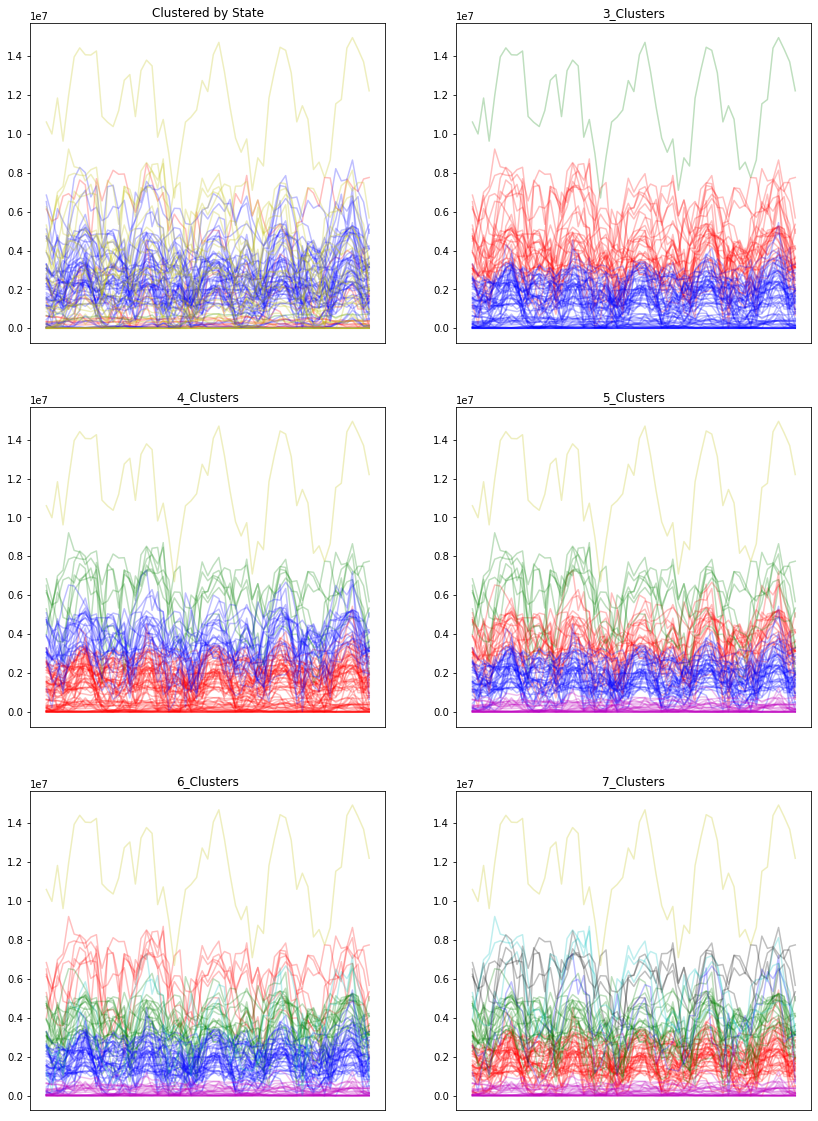

In [76]:
print('Hierarchical Clustering: Raw Data, Zeros Dropped, Raw Data Visualization')
results = cluster_k_results (norm=False, dezero=True, norm_vis=None, k=7, model='hierarchical',
                             dist = True, plot=True)
results

Hierarchical Clustering: Normalized Data, Zeros Dropped, Normalized Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           29  11  51   1, state       FL  MI  TX  WA
2_Clusters                
0            2   2   5   0
1           27   9  46   1, state       FL  MI  TX  WA
3_Clusters                
0           27   9  46   1
1            1   2   5   0
2            1   0   0   0, state       FL  MI  TX  WA
4_Clusters                
0            1   2   5   0
1           27   9  45   1
2            1   0   0   0
3            0   0   1   0, state       FL  MI  TX  WA
5_Clusters                
0            1   2   3   0
1           27   9  45   1
2            1   0   0   0
3            0   0   1   0
4            0   0   2   0, state       FL  MI  TX  WA
6_Clusters                
0            1   1   0   0
1           27   9  45   1
2            0   1   3   0
3            0   0   1   0
4            0   0   2   0
5            1   0   0   0, state       FL  MI  

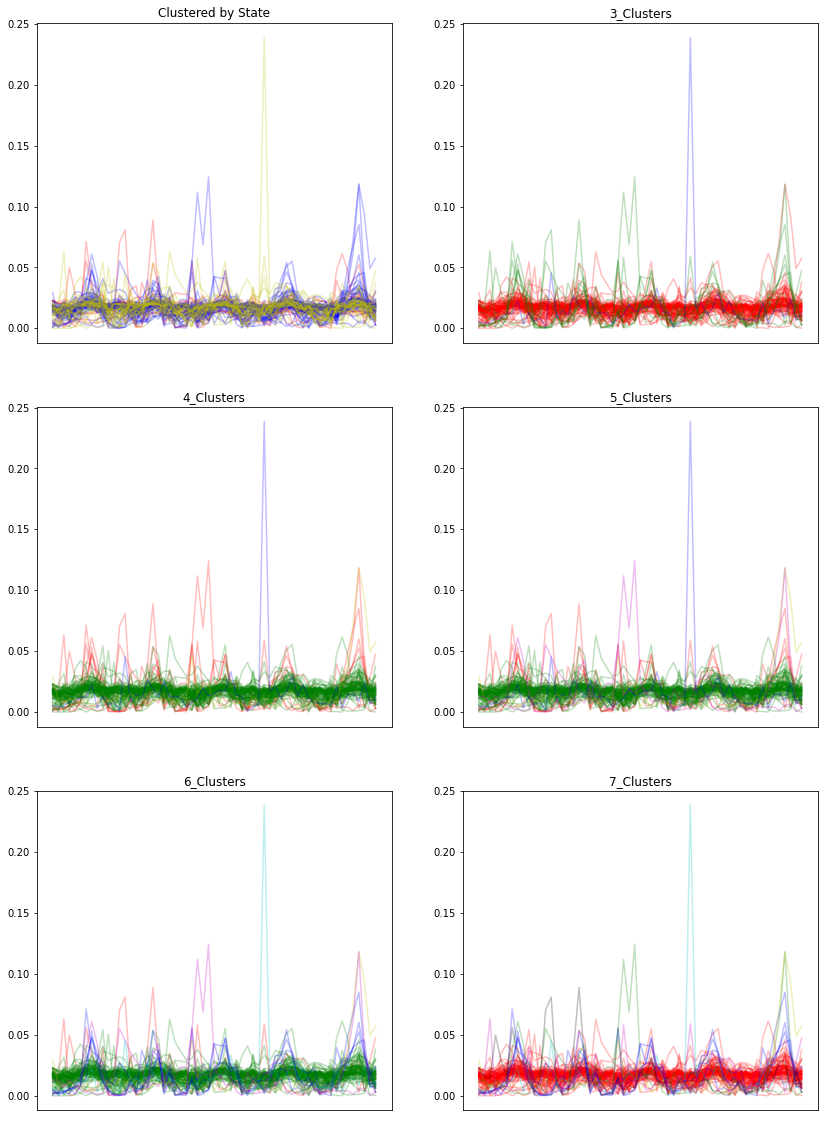

In [77]:
print('Hierarchical Clustering: Normalized Data, Zeros Dropped, Normalized Visualization')
results = cluster_k_results (norm=True, dezero=True, norm_vis=True, k=7, model='hierarchical',
                             dist = True, plot=True)
results

KMediod Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           29  11  51   1, state       FL  MI  TX  WA
2_Clusters                
0           14   6  23   0
1           15   5  28   1, state       FL  MI  TX  WA
3_Clusters                
0           13   2  22   0
1            4   3   7   0
2           12   6  22   1, state       FL  MI  TX  WA
4_Clusters                
0            8   2   8   0
1            1   1   4   0
2            2   2   9   0
3           18   6  30   1, state       FL  MI  TX  WA
5_Clusters                
0           10   6  21   1
1            1   1   4   0
2            8   0   8   0
3            4   2  15   0
4            6   2   3   0, state       FL  MI  TX  WA
6_Clusters                
0           11   6  22   1
1            1   2   6   0
2            6   0   4   0
3            4   2  12   0
4            1   1   1   0
5            6   0   6   0, state       FL  MI  TX  WA


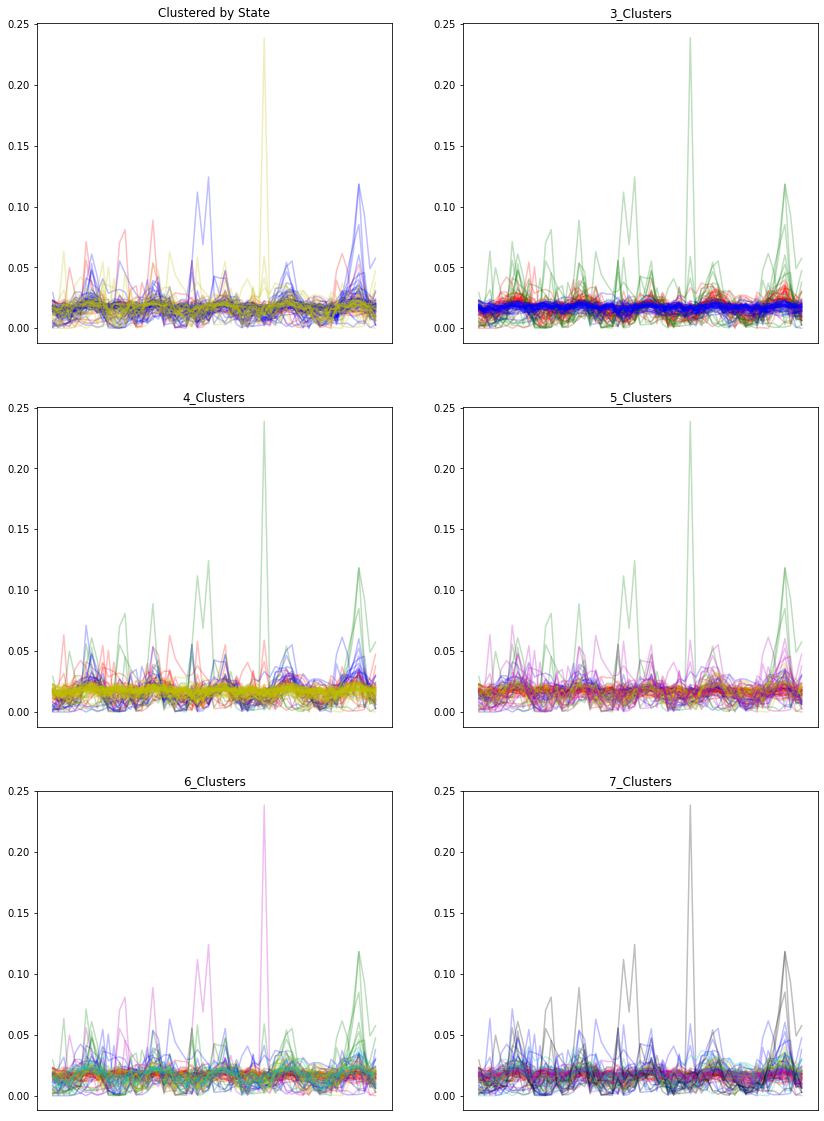

In [78]:
print('KMediod Clustering: Normalized Data, Zeros Dropped, Normalized Visualization')
results = cluster_k_results (norm=True, dezero=True, norm_vis=True, k=7, model='KMediods',
                             dist = True, plot=True)
results

KMediod Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           29  11  51   1, state       FL  MI  TX  WA
2_Clusters                
0           14   6  23   0
1           15   5  28   1, state       FL  MI  TX  WA
3_Clusters                
0           13   2  22   0
1            4   3   7   0
2           12   6  22   1, state       FL  MI  TX  WA
4_Clusters                
0            8   2   8   0
1            1   1   4   0
2            2   2   9   0
3           18   6  30   1, state       FL  MI  TX  WA
5_Clusters                
0           10   6  21   1
1            1   1   4   0
2            8   0   8   0
3            4   2  15   0
4            6   2   3   0, state       FL  MI  TX  WA
6_Clusters                
0           11   6  22   1
1            1   2   6   0
2            6   0   4   0
3            4   2  12   0
4            1   1   1   0
5            6   0   6   0, state       FL  MI  TX  WA


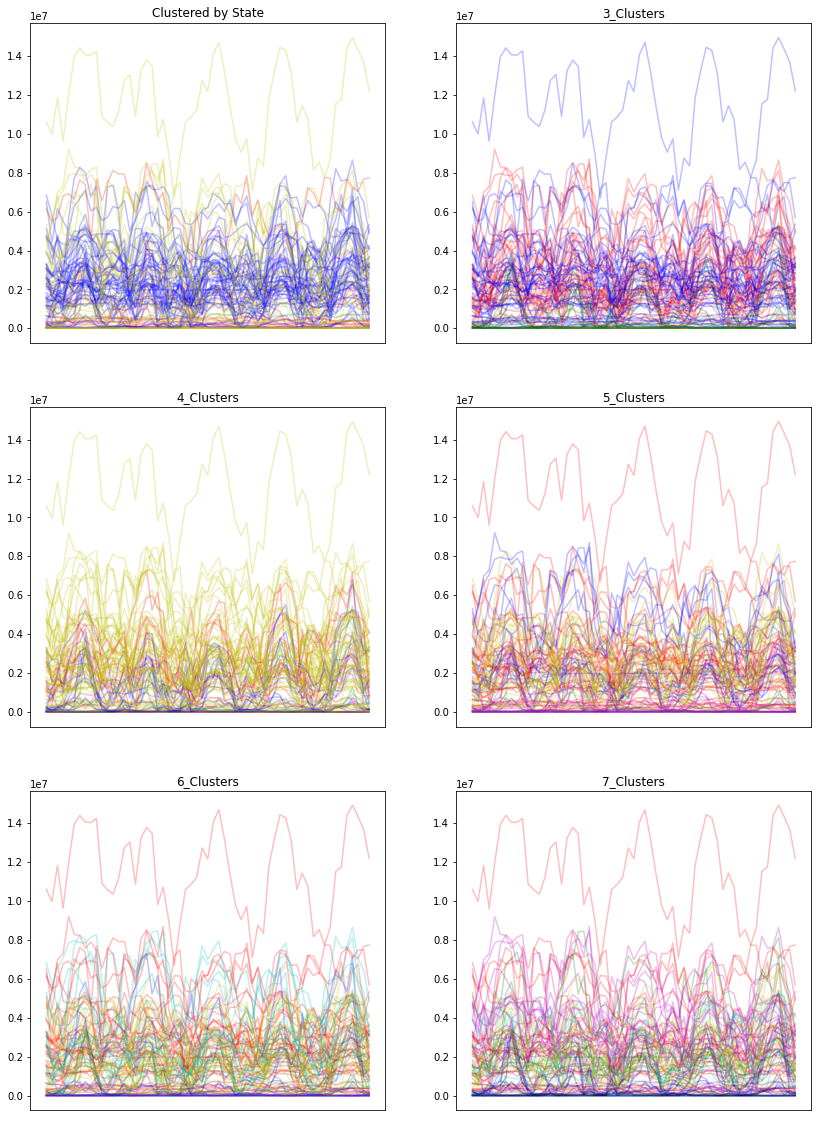

In [79]:
print('KMediod Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization')
results = cluster_k_results (norm=True, dezero=True, norm_vis=False, k=7, model='KMediods',
                             dist = True, plot=True)
results

KMediod Clustering: Raw Data, Zeros Dropped, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           29  11  51   1, state       FL  MI  TX  WA
2_Clusters                
0           19  10  34   1
1           10   1  17   0, state       FL  MI  TX  WA
3_Clusters                
0            9   1  36   0
1            6   1   3   0
2           14   9  12   1, state       FL  MI  TX  WA
4_Clusters                
0            7   1  22   0
1            5   1   2   0
2           10   7   6   1
3            7   2  21   0, state       FL  MI  TX  WA
5_Clusters                
0            5   0  16   0
1           10   7   6   1
2            0   1   4   0
3            5   1   2   0
4            9   2  23   0, state       FL  MI  TX  WA
6_Clusters                
0            5   0  11   0
1           10   7   6   1
2            0   1   4   0
3            5   1   2   0
4            7   1  16   0
5            2   1  12   0, state       FL  MI  TX  WA
7_Clust

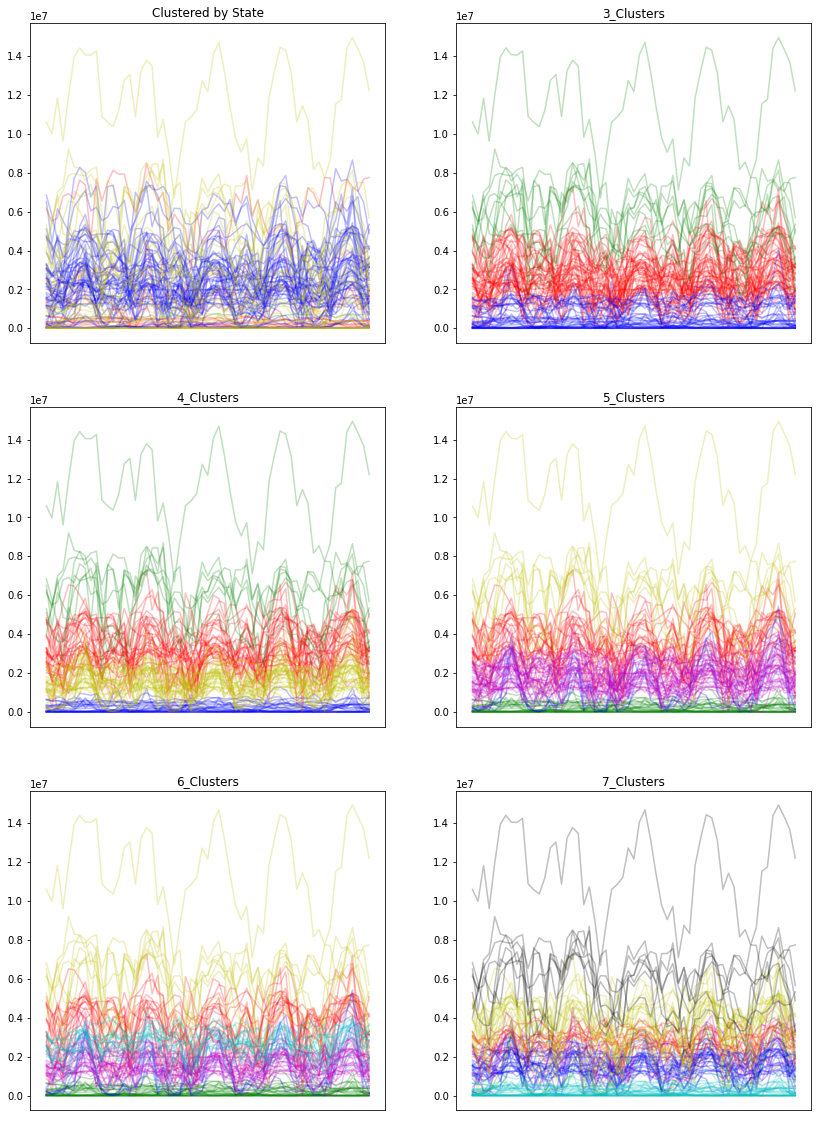

In [80]:
print('KMediod Clustering: Raw Data, Zeros Dropped, Raw Data Visualization')
results = cluster_k_results (norm=False, dezero=True, norm_vis=False, k=7, model='KMediods',
                             dist = True, plot=True)
results

KMediod Clustering: Normalized Data, All Data, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           42  19  74   9, state       FL  MI  TX  WA
2_Clusters                
0            3   1   1   0
1           39  18  73   9, state       FL  MI  TX  WA
3_Clusters                
0            3   1   1   0
1            8  10  12   3
2           31   8  61   6, state       FL  MI  TX  WA
4_Clusters                
0            3   1   1   0
1            2   6   6   2
2           27   8  44   4
3           10   4  23   3, state       FL  MI  TX  WA
5_Clusters                
0            3   1   1   0
1            8   2  16   3
2           21   8  38   4
3            7   1  14   1
4            3   7   5   1, state       FL  MI  TX  WA
6_Clusters                
0            3   1   1   0
1            3   3   8   2
2           22   8  39   2
3            0   4   1   1
4            2   3   3   0
5           12   0  22   4, state       FL  MI  TX  WA
7_Clu

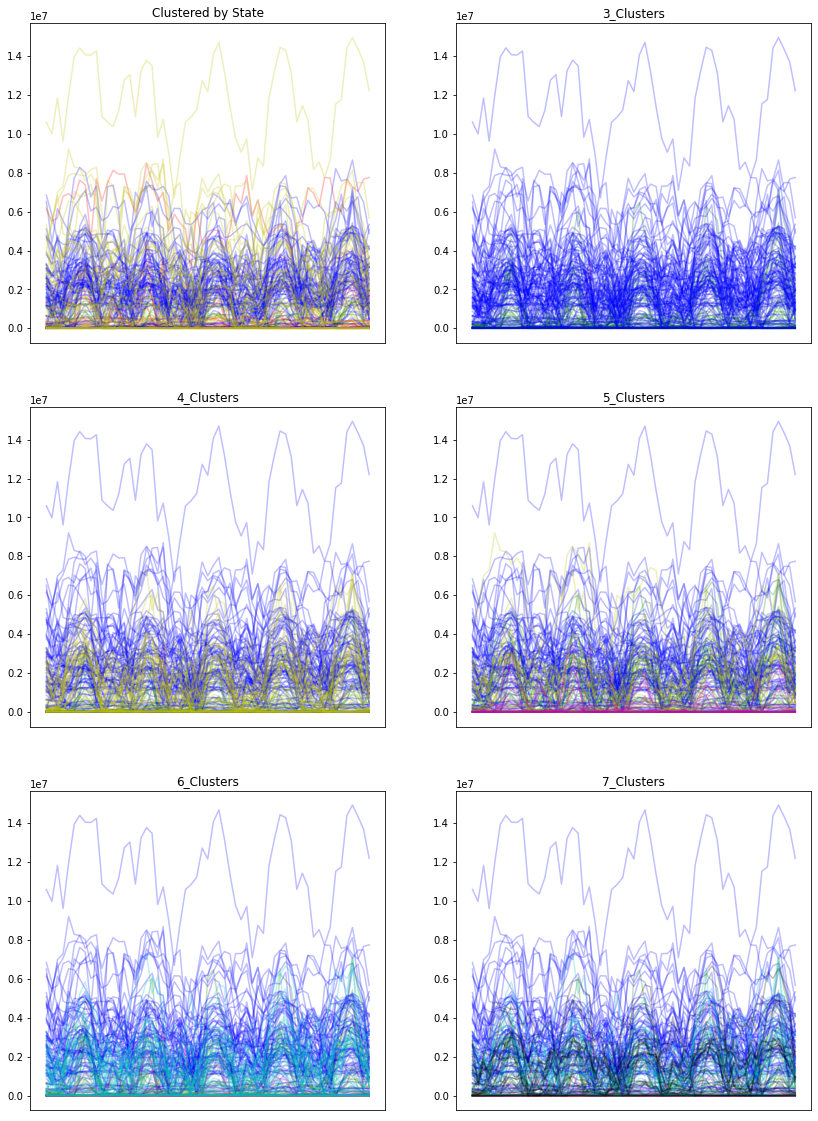

In [83]:
print('KMediod Clustering: Normalized Data, All Data, Raw Data Visualization')
results = cluster_k_results (norm=True, dezero=False, norm_vis=False, k=7, model='KMediods',
                             dist = True, plot=True)
results

KMediod Clustering: Raw Data, All Data, Raw Data Visualization
[state       FL  MI  TX  WA
1_Clusters                
0           29  11  51   1, state       FL  MI  TX  WA
2_Clusters                
0           19  10  34   1
1           10   1  17   0, state       FL  MI  TX  WA
3_Clusters                
0            9   1  36   0
1            6   1   3   0
2           14   9  12   1, state       FL  MI  TX  WA
4_Clusters                
0            7   1  22   0
1            5   1   2   0
2           10   7   6   1
3            7   2  21   0, state       FL  MI  TX  WA
5_Clusters                
0            5   0  16   0
1           10   7   6   1
2            0   1   4   0
3            5   1   2   0
4            9   2  23   0, state       FL  MI  TX  WA
6_Clusters                
0            5   0  11   0
1           10   7   6   1
2            0   1   4   0
3            5   1   2   0
4            7   1  16   0
5            2   1  12   0, state       FL  MI  TX  WA
7_Clusters  

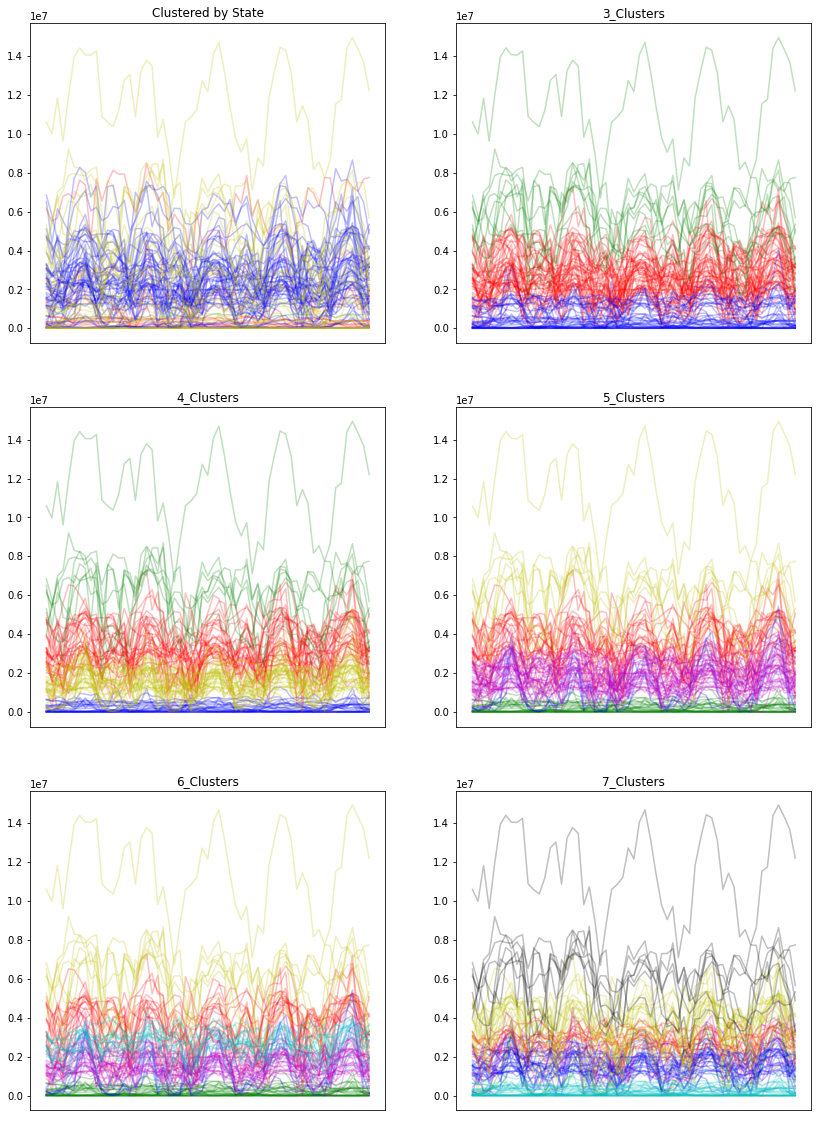

In [95]:
print('KMediod Clustering: Raw Data, All Data, Raw Data Visualization')
results = cluster_k_results (norm=False, dezero=True, norm_vis=False, k=7, model='KMediods',
                             dist = True, plot=True)
results

Hierarchical Clustering: Raw Data, All Data, Raw Visualization
[state       FL  MI  TX  WA
6_Clusters                
0            3   0  13   0
1           25  15  25   8
2            4   1   2   0
3            1   0   0   0
4            7   0  11   0
5            6   3  27   1]


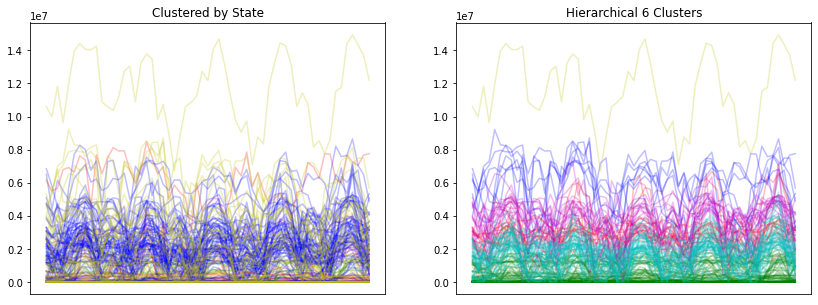

In [104]:
print('Hierarchical Clustering: Raw Data, All Data, Raw Visualization')
cluster_result (norm=None, dezero=None, norm_vis=None, k=6, model='hierarchical',
                    damping=.05, max_iter=200, eps=0.5, min_samples=5,
                    dist=True, plot=True, geoplot=None, title='Hierarchical')